##### Version 0.01 -- Travanj 2017

# Source panel method

Do sada smo mogli uočiti da superpozicija [doublet-a](03_dublet.ipynb) i uniformnog toka može *dati* strujanje oko cilindra (s kružnim poprečnim presjekom) te da je u tom slučaju *drag* jednak nuli (*D'Alembert-ov paradoks*). Ako dodamo [vrtlog](05_vortex_uzgon.ipynb) u centar cilindra, tada je uzgon proporcionalan cikulaciji (*Kutta-Joukowski teorem*): $L=\rho U \Gamma$. 

Dodavanje osnovnih rješenja potencijalnog toka i interpretiranje *dividing streamline* kao krutog tijela se često još naziva *indirektna metoda* (Rankine, još 1871). Primjenjivost je prilično ograničena zbog činjenice što je teško ili gotovo nemoguće specificirati geometriju oko koje fluid treba optjecati.

Prethodna [lekcija](08_strujanje_oko_cilindra.ipynb), pokazuje da je moguće prvo definirati geometriju i onda izračunati intenzitete izvora na panelima koji opisuju tijelo (strujanje je tangencijalno na povrišini). Takva metoda se još naziva *direktna metoda* za koju su zaslužni Hess i Smith iz Douglas Aircraft Company 1960-ih.

Skup panela (2D dužina) može predstavljati površinu bilo kojeg tijela *uronjenog* u uniformni tok na način da intenzitete izvora postavimo takvim da je normalna brzina na svakom panelu jednaka nuli. Kako su paneli povezani, potrebno je riješiti sustav linearnih jednadžbi.

Možemo kreirati proizvoljnu geometriju s panelima! Samo nam trebaju točke koje definiraju takvu geometriju. Ovdje ćemo koristiti datoteku koja opisuje geometriju **NACA0012 airfoil**, kreirati panele, izračunati intenzitete izvora *source sheet-ova* i dobiti strujanje oko profila krila aviona.


Kao i do sada, import modula:

In [6]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

Sada ćemo učitati geometriju iz datoteke koristećo NumPy funkciju [`loadtxt()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html). Datoteka se može skinuti s  [Airfoil Tools](http://airfoiltools.com/airfoil/details?airfoil=n0012-il) mrežne stranice i sadrži koordinate standardnog NACA0012 simetričnog profila. Datoteka je snimljena u `resources` mapi, iz koje ćemo *pročitati* datoteku.

Točke geometrije su učitane u NumPy listu te ćemo razdijeliti podatke u dvije liste, `x,y` (samo zbog bolje čitljivosti koda). Na kraju ćemo prikazati geometriju.

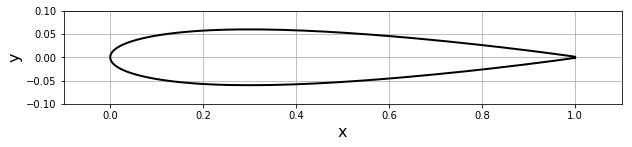

In [7]:
# read of the geometry from a data file
naca_filepath = os.path.join('resources', 'naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

## Diskretizacija na panele

Kao i u prethodnoj [lekciji](08_strujanje_oko_cilindra.ipynb), kreirat ćemo diskretizaciju geometrije kao panele(opet, 2D dužine). Atributi panela su: početna, krajnja i njegovo poloviše, duljina i orijentacija.  Dolje je slika...

<img src="./resources/panelSketch.png" width="400">

Malo ćemo promijeniti već postojeću klasu `Panel` iz prethodne lekcije: Jedina razlika je identifikacija gornje i donje površine sa stringovima `upper` i `lower`, što će biti korišteno za crtanje rezultata s različitim bojama, odnosno, mijenjamo klasu samo zbog dekoracije! Iako je za ovako male projekte sasvim opravdano tako mijenjati klasu, ovakvi zahvati su zabranjeni unutar većih projekata.

In [8]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

Diskretizacija cilindra sa kružnim poprečnim presjeko je bila prilično jednostavna, dok je diskretizacija kompleksnijih oblika, pogodili ste, kompleksnija. Ipak rješavač je efektivno isti kao i u prethodnoj [lekciji](08_strujanje_oko_cilindra.ipynb).

Donja funkcija će kreirati panele iz geometrije koja je učitana iz datoteke. Bolje je kreirati manje panele na početku i na kraju profile (tamo gdje je zakrivljenost veća). Pragmatično rješenje za kreiranje uniformne distribucije oko profila je prvo diskretizirati kružnicu s promjerom tetive profila, kako je prikazano na donjoj skici:

<img src="./resources/naca0012_in_circle.png" width="300">

Sada spremimo $x$ koordinate kružnice, `x_circle`, koje će biti $x$ koordinate čvorova panela`x` i projicirati $y$ koordinate točaka kružnice na točka na profilu. Time dobijemo distribuciju na profilu koja je ugušćena upravo tamo gdje je potrebno:

<img src="./resources/naca0012_discretized_in_circle.png" width="300">

Funkcija koja koristi takvu metodu diskretizacije (a nazvat ćemo je `define_panels()`) mora vratiti listu objekata, a svaka je instanca klase `Panel` koja će sadržavati sve informacije o panelu.

Par primjedbi o funkciji `define_panels()`:

* moramo izračunati $x$ koordinate kružnice (`x_circle`) jer će $y$ koordinate panela biti izračunate interpolacijom;
* kreirat ćemo kružnicu s `N+1` tačaka, ali prva i zadnja točka moraju biti iste;
* proširit ćemo naše NumPy liste dodavanjem dodatnog elementa (koji je jednak prvom elementu); čime nije potrebno raditi ništa specijalno s elementom `x[i+1]` u petljama;
* *while* petlja se koristi za pronalaženje dvaju uzastopnih točaka, (`x[I]`,`y[I]`) i (`x[I+1]`,`y[I+1]`), na profilu tako da interval [`x[I]`,`x[I+1]`] sadrži element `x_ends[i]`; koristit ćemo ključnu riječ `break` za izlaz iz petlje;
* jednom kada nađemo dvije točke, element `y_ends[i]` će biti izračunat interpolacijom.

In [9]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max()-x.min())/2                                    # radius of the circle
    x_center = (x.max()+x.min())/2                             # x-coord of the center
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  # x-coord of the circle points
    
    x_ends = numpy.copy(x_circle)      # projection of the x-coord on the surface
    y_ends = numpy.empty_like(x_ends)  # initialization of the y-coord Numpy array

    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

Sada ćemo iskoristiti funkciju s predefiniranim brojem panela i nacrtati dobivenu geometriju.

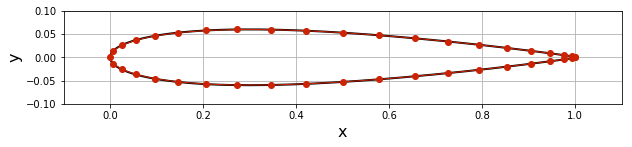

In [10]:
N = 40                            # number of panels
panels = define_panels(x, y, N)   # discretizes of the geometry into panels

# plot the geometry and the panels
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

## Uniformni tok

Profil NACA0012 će biti *uronjen* u uniformni tok s brzinom $U_\infty$ i kutem upada $\alpha=0$. Samo zato što možemo, kreirat ćemo klasu za uniformni tok. Iako sam načelno protiv kreiranja klasa, ovdje mi se čini da je kod čitljiviji ako koristimo klasu...
Također, jednostavnije je proslijediti objekt funkciji nego više atributa.

In [11]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

In [12]:
# define and creates the object freestream
u_inf = 1.0                                # freestream spee
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

## Rubni uvjet tangencijalnog strujanja na površini profila

Postavljanje rubnog uvjeta za svaku *kontrolnu točku* diskretizirane geometrije rezultira sljedećim: takva geometrija odgovara *dividing* strujnici (ta aproksimacija postaje točnija s povećanjem broja panela). Dakle, za svaki panel $i$, smatramo $u_n=0$ na $(x_{c_i},y_{c_i})$, što nas dovodi do jednadžbe iz prethodne lekcije:

\begin{equation}
u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0
\end{equation}

odnosno,

\begin{equation}
0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{equation}

U gornjoj jednadžbi računamo derivaciju potencijala u normalnom smjeru u cilju nametanja tangencijalnog strujanja na svakom panelu. Kasnije tebamo izračunati tu derivaciju (u tangencijalnom smjeru) da možemo izračunati koeficijent tlaka. Također smo prilično zainteresirani nacrtati sliku strujanja na mreži, št opet znači izračunati derivaciju u $x$ i $y$ smjeru.

Donja funkcija je slična implementiranoj funkciji iz prošle Therefore the function below is similar to the one implemented in [lekcije](08_strujanje_oko_cilindra.ipynb), kojom izračunavamo integrale duže svakog panela. Ipak nju sada generaliziramo na način da se *prilagodimo* smjeru derivacije (sa dva nova argumenta `dxdz` i `dydz`), koji predstavljaju vrijednosti $\frac{\partial x_{c_i}}{\partial z_i}$ i $\frac{\partial y_{c_i}}{\partial z_i}$. $z_i$ je željeni smjer.

Nadalje, funkcija je općenitija jer dopušta evaluaciju u bilo kojoj točki, ne samo u kontrolnoj točki panela. Argument `p_i` je zamijenjen koordinatama `x` i `y` kontrolne točke, dok je `p_j` zamijenje s `panel`.

In [13]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

## Kreiranje linearnog sustava

Ovdje ćemo kreirati linearni sustav jednadžbi 

\begin{equation}[A][\sigma] = [b].\end{equation}

Morat ćemo pozvati funkciju `integral()` s pravilnim vrijednostima za zadnje parametre,  $\cos \beta_i$ and $\sin\beta_i$, koji odgovaraju derivacijama u normalnom smjeru.

Napokon, pozvat ćemo NumPy `linalg.solve()` funkciju kojom ćemo riješiti sustav i *dobiti* intenzitete svakog panela.

In [14]:
def build_matrix(panels):
    """
    Builds the source matrix.
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    return b

In [15]:
A = build_matrix(panels)                    # compute the singularity matrix
b = build_rhs(panels, freestream)           # compute the freestream RHS

In [16]:
# solve the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

## Koeficijent tlaka na površini profila

Iz Bernoullijeve jednadžbe:  koeficijent tlaka na $i$-tom panelu:

\begin{equation}C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2
\end{equation}

gdje je $u_{t_i}$ tangencijalna komponenta brzine na polovištu $i$-tog panela,

\begin{equation}
u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{equation}

sa

\begin{equation}
\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i
\end{equation}

Primijetite da pozivamo funkciju `integral()` s različitim parametrima: $-\sin\beta_i$ i $\cos\beta_i$ da dobijemo derivaciju u tangencijalnom smjeru.

In [17]:
def get_tangential_velocity(panels, freestream):
    """
    Computes the tangential velocity on the surface of the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [18]:
# compute the tangential velocity at the center-point of each panel
get_tangential_velocity(panels, freestream)

In [19]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [20]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

### Točno, teoretsko rješenje

Točno rješenje karakteristika profila se može dobiti pomoću *Theodorsenove metode*. Ono koristi tzv. Joukowski transformaciju, ali može dati rješenje za bilo koji profil, ali to je već izvan našeg promatranja. Rezultirajuće vrijednosti koeficijenta tlaka za neke profile su dati u [NACA Report No.824](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf) izdanom 1945, a nalaze se na NASA web serveru. 

Vrijednosti $(u/U_{\infty})^2$ su dane za nekoliko lokacija duže tetive profila. Ovdje su predstavljeni kao lista:

In [21]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [22]:
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100
print(xtheo)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


### Crtanje!

Preuzete vrijednosti iz NACA izvještaja (dostupni i u knjizi Abbot and von Doenhoff, ["Theory of Wing Sections,"](http://books.google.com/books/about/Theory_of_Wing_Sections_Including_a_Summ.html?id=DPZYUGNyuboC) 1949) i usporediti distribuciju tlaka s našom metodom.

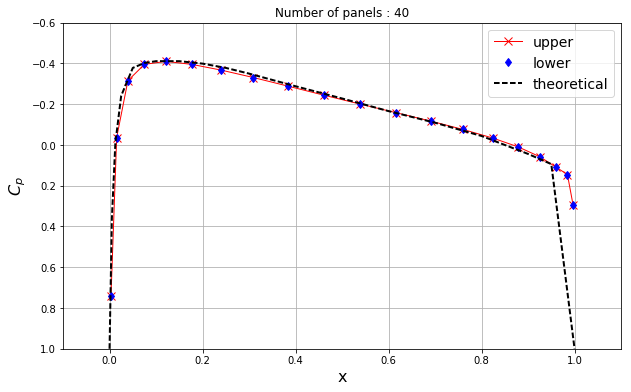

In [23]:
# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels : %d' % N);

Nij loše, ali... *Trailing edge* se ne podudara s Theordorsenovom metodom. Uzrok? Uvjet tangencijalnog strujanja se nameće na polovištu panela, a ne na krajnjim točkama panela.

##### Provjera točnosti

Suma svih intenziteta izvora mora iznositi nula za zatvoreno tijelo. Ako to nije zadogoljeno, to bi značilo da tijelo dodaje ili apsorbira masu u ili iz fluida. Mora vrijediti

$$\sum_{j=1}^{N} \sigma_j l_j = 0$$

gdje je $l_j$ duljina $j^{\text{tog}}$ panela.

Ovo je prilično dobra metoda procjene točnosti source panel metode.

In [24]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths: {}'.format(accuracy))

--> sum of source/sink strengths: 0.004617031175283098


## Strujnice

Ako želimo dobiti strujnice, moramo kreirati mrežu i izračunati polje brzina.  Kako znamo intenzitet svakog panela, možemo izračunati $x$ komponentu brzine derivirajući potencijal brzine u $x$ smjeru, a $y$ komponente brzine derivirajući potencijal brzine  u $y$ smjeru:

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Primijetite da pozivamo funkciju `integral()` s $1,0$ kada računamo derivacije u $x$ smjeru, a $0,1$ za derivacije u $y$ smjeru.

I ovdje koristimo `numpy.vectorize()` da izbjegnemo *nested loops*.

In [25]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1, 0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0, 1)
    
    return u, v

In [26]:
# define a mesh grid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

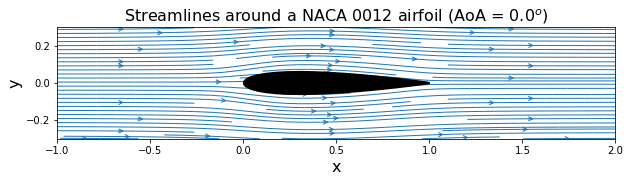

In [27]:
# plot the velocity field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha), fontsize=16);

Sada smo spremni izračunati koeficijent tlaka oko profila.

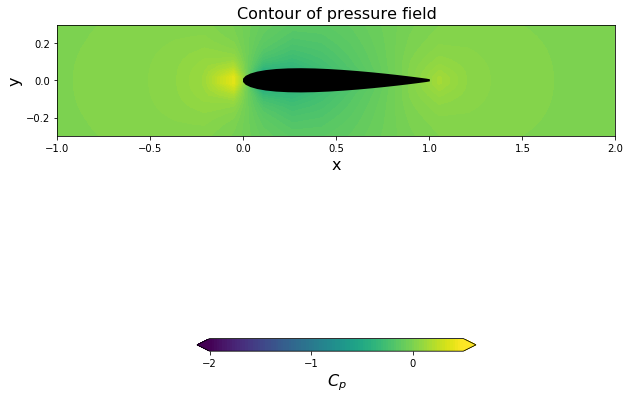

In [37]:
# compute the pressure field
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# plot the pressure field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 0.5, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);

## Reference

1. [Airfoil Tools](http://airfoiltools.com/index), website providing airfoil data.
1. Ira Herbert Abbott, Albert Edward Von Doenhoff and Louis S. Stivers, Jr. (1945), "Summary of Airfoil Data," NACA Report No.824, [PDF on the NASA web server](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf) (see p. 71)
1. Ira Herbert Abbott, Albert Edward Von Doenhoff, "Theory of Wing Sections, Including a Summary of Airfoil Data" (1949), Dover Press. 

A further reference on Theodorsen's method is:

* Roland Schinzinger, Patricio A. A. Laura (1991), "Conformal Mapping: Methods and Applications." Dover edition in 2003. [Read on Google Books](https://books.google.com/books?id=qe-7AQAAQBAJ&lpg=PA128&ots=wbg0jLlqq5&dq=method%20theodorsen&pg=PA128#v=onepage&q=%22method%20of%20theodorsen%20and%20garrick%22&f=false)


---

###### Ignorirati dolje: load stila

In [29]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()